In [1]:
# Here I perform cleaning and preliminary analysis of the single cell data
## UMAPs, Cell Proportion calculations, Pseudobulk count generation
### Loading a .h5ad file requires significant amounts of RAM (300+ GB)

In [2]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.stats import linregress
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
import scanpy.external as sce

import statsmodels.api as sm
from statsmodels.formula.api import ols


Running Scanpy 1.9.3, on 2024-08-13 13:21.


In [3]:
# Figure settings
mpl.rcdefaults()
# Set font to be arial
# mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rc('font', **{'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

# sc.settings.set_figure_params(dpi=120)

In [19]:
# Load data 
## WARNING, THIS OBJECT IS LARGE, DEVICE MUST HAVE CONSIDERABLE AMOUNT OF RAM TO LOAD
adata = sc.read_h5ad(
    "../sc_files/local.h5ad")
adata

AnnData object with n_obs × n_vars = 1263676 × 30933
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [20]:
## Extract age, rename columns for analysis


adata.obs['age'] = adata.obs['development_stage'].str[:2]
adata.obs['age'] = adata.obs['age'].astype(int)
adata.obs = adata.obs.rename(columns={'ind_cov': 'cohort_id', 'self_reported_ethnicity' : 'raceeth', 'donor_id' : 'subject_id'})


In [21]:
# Use gene name instead of gene symbols
adata.var = adata.var.reset_index().set_index("feature_name")
adata.var_names = adata.var.index
adata.var.head()

/home/rithwik.narendra/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/rithwik.narendra/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:887: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


,index,feature_is_filtered,feature_reference,feature_biotype
feature_name,,,,
MIR1302-2HG,ENSG00000243485,True,NCBITaxon:9606,gene
FAM138A,ENSG00000237613,True,NCBITaxon:9606,gene
OR4F5,ENSG00000186092,True,NCBITaxon:9606,gene
RP11-34P13.7,ENSG00000238009,True,NCBITaxon:9606,gene
RP11-34P13.8,ENSG00000239945,True,NCBITaxon:9606,gene


In [22]:
## Remove FLARE samples
adata.obs['FLARE?'] = adata.obs['cohort_id'].str[:5]
adata = adata[adata.obs['FLARE?']!='FLARE',:]

In [23]:
## Count controls
adata.obs['ControlCheck'] = adata.obs['cohort_id'].astype(str).map(len)

adata.obs.head()

<ipython-input-23-0391aa9132ed>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['ControlCheck'] = adata.obs['cohort_id'].astype(str).map(len)
/home/rithwik.narendra/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,library_uuid,assay_ontology_term_id,mapped_reference_annotation,is_primary_data,cell_type_ontology_term_id,author_cell_type,cell_state,sample_uuid,tissue_ontology_term_id,development_stage_ontology_term_id,...,assay,disease,organism,sex,tissue,raceeth,development_stage,age,FLARE?,ControlCheck
index,,,,,,,,,,,,,,,,,,,,,
CAAGGCCAGTATCGAA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,3332f018-936e-4c4c-9105-99d9503db5a3,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,0a1148dc-356f-4dc4-9c32-bf0823257d93,UBERON:0000178,HsapDv:0000122,...,10x 3' v2,normal,Homo sapiens,female,blood,Asian,28-year-old human stage,28,HC-54,6
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,70a004b7-4a17-4702-8910-4557aa0c4279,EFO:0009899,GENCODE 19,True,CL:0000860,cM,na,577bce84-8d37-4851-9fb4-53f9467699ba,UBERON:0000178,HsapDv:0000139,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,45-year-old human stage,45,1132_,9
GGCTCGATCGTTGACA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,c2641f62-eb23-4dad-9c22-b52e72b79df2,EFO:0009899,GENCODE 19,True,CL:0000236,B,na,5e0ed28c-a75a-4ecd-a0c7-49e71264690b,UBERON:0000178,HsapDv:0000165,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,71-year-old human stage,71,1110_,9
ACACCGGCACACAGAG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,222b358b-71e7-4b0f-9f9b-47b4c67aaa27,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,982d60b4-5677-4e2d-8b58-79503863710d,UBERON:0000178,HsapDv:0000122,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,28-year-old human stage,28,1479_,9
TCGTAGATCCTTGGTC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0,0c7c125d-46d6-40ba-8088-31fb2b526a78,EFO:0009899,GENCODE 19,True,CL:0000625,T8,na,fc11ebf7-2767-4d92-96f9-a57af8f1be30,UBERON:0000178,HsapDv:0000146,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,52-year-old human stage,52,1334_,9


In [24]:

## Separate the data into a control group and Lupus group

adata.obs['Group'] = adata.obs['ControlCheck'] == 9
adata.obs['Group'] = pd.Series(np.where(adata.obs.Group == True, 'Lupus', 'Control'),
          adata.obs.index)

## Separate the data by study 
col = 'ControlCheck'
conditions  = [ adata.obs[col] == 9, (adata.obs[col] == 5) | (adata.obs[col] == 6) | (adata.obs[col] == 11), adata.obs[col] > 11 ]
choices     = [ "CLUES", 'CLUES Controls', 'IMMVAR' ]
adata.obs["Study"] = np.select(conditions, choices, default=np.nan) 
adata.obs['Study'] = adata.obs['Study'].astype('category')
adata.obs["Study"].cat.categories

Index(['CLUES', 'CLUES Controls', 'IMMVAR'], dtype='object')

In [25]:
## Remove IMMVAR samples due to age distribution skew

adata = adata[adata.obs['Study']!='IMMVAR',:]

In [26]:
adata.obs["Study"].cat.categories

Index(['CLUES', 'CLUES Controls'], dtype='object')

In [27]:
adata.obs["ct_cov"].cat.categories

Index(['T4_naive', 'T8_naive', 'T4_em', 'T4_reg', 'CytoT_GZMH+', 'CytoT_GZMK+',
       'T_mait', 'NK_bright', 'NK_dim', 'B_naive', 'B_mem', 'B_plasma',
       'B_atypical', 'Progen'],
      dtype='object')

In [28]:
## Rename cell types

mapping = {
    'T4_naive': 'CD4 Naive',
    'T8_naive': 'CD8 Naive',
    'T4_em': 'CD4 EM',
    'T4_reg': 'CD4 Reg',
    'CytoT_GZMH+': 'CD8 GZMH',
    'CytoT_GZMK+': 'CD8 GZMK',
    'T_mait': 'T MAIT',
    'NK_bright': 'NK Bright',
    'NK_dim': 'NK Dim',
    'B_naive': 'B Naive',
    'B_mem': 'B Mem',
    'B_plasma': 'B Plasma',
    'B_atypical': 'B Atypical',
    'Progen': 'Progen',
    np.nan: 'Myeloid',
}
adata.obs['expanded_names'] = adata.obs['ct_cov'].map(mapping)
adata.obs['expanded_names'] = np.where(adata.obs['expanded_names'].isnull(), 'Myeloid', adata.obs['expanded_names'])
adata.obs["expanded_names"] = pd.Categorical(adata.obs["expanded_names"])

<ipython-input-28-2d27ed7889d4>:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['expanded_names'] = adata.obs['ct_cov'].map(mapping)


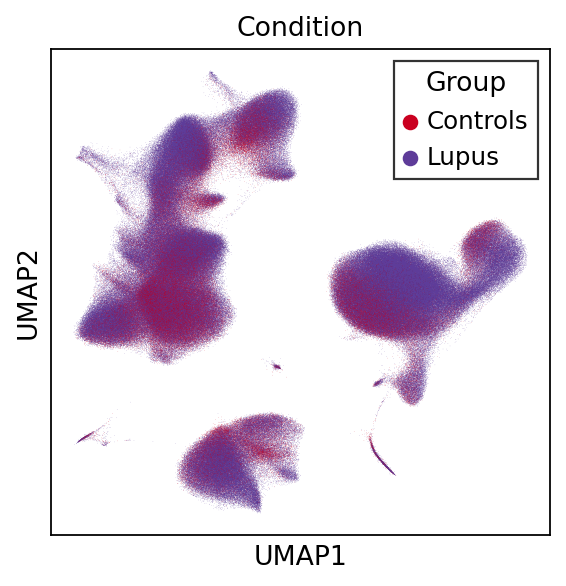

In [5]:
# Create UMAP plot by condition

import matplotlib.colors as mcolors
cadetblue1_rgb = mcolors.hex2color("#ca0020") 
chocolate2_rgb = mcolors.hex2color("#5e3c99")  
sc.set_figure_params(scanpy=True, fontsize=12)
fig = sc.pl.umap(adata, color=["Group"], palette={'Control': cadetblue1_rgb, 'Lupus': chocolate2_rgb}, title="Condition", return_fig = True)
handles, labels = fig.axes[0].get_legend_handles_labels()
new_labels = ['Controls' if label == 'Control' else label for label in labels]
fig.axes[0].legend(handles, new_labels, loc='best', title='Group')
plt.savefig('conditionumap_plot.png', dpi=600, bbox_inches='tight')
plt.show()

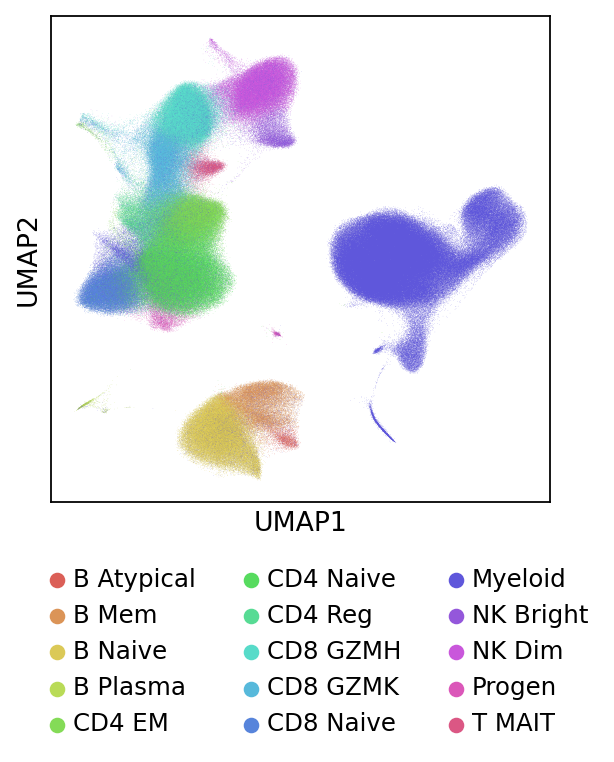

In [36]:
# Create UMAP plot by cell type

sc.set_figure_params(scanpy=True, fontsize=12)
fig = sc.pl.umap(adata, color=["expanded_names"], palette=sns.color_palette("hls",15), return_fig = True)
ax=fig.axes[0]

leg = ax.get_legend()
if leg:
    leg.set_visible(False)
ax.set_title('')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.6, -0.25), ncol=3, frameon = False, fontsize = 11)
plt.savefig('umap_plot.png', dpi=1200, bbox_inches='tight')

In [12]:
# Compare Lupus and controls

Lupus = adata[adata.obs['Group']=='Lupus',:]
HC = adata[adata.obs['Group']=='Control',:]

In [37]:
adata.write_h5ad('jul162024.h5ad')

In [4]:
adata = sc.read_h5ad(
    "jul162024.h5ad")

# Cell Type Proportions

### Author Cell Type



In [17]:
## Set up cell type proportions

cell_prop = adata.obs.groupby(["subject_id","ct_cov"]).size()/adata.obs.groupby(["subject_id"]).size()
cell_prop.name = "prop"
cell_prop.head()

subject_id  ct_cov     
1004        T4_naive       0.253681
            T8_naive       0.082999
            T4_em          0.107764
            T4_reg         0.051539
            CytoT_GZMH+    0.081325
Name: prop, dtype: float64

In [18]:
cell_prop = pd.DataFrame(cell_prop).reset_index(level="ct_cov")
cell_prop.head()

,ct_cov,prop
subject_id,,
1004,T4_naive,0.253681
1004,T8_naive,0.082999
1004,T4_em,0.107764
1004,T4_reg,0.051539
1004,CytoT_GZMH+,0.081325


In [19]:
## Merge proportion data with relevant metadata

metadata = adata.obs[["age","sex","raceeth", "subject_id", "ControlCheck", "Group", "Study"]].copy()
metadata = metadata.drop_duplicates("subject_id")
batch_prop = cell_prop.copy()
cell_prop = cell_prop.merge(metadata, how="left",
                            left_index=True, right_on="subject_id")

In [20]:
## Extract control samples

control = cell_prop.loc[cell_prop['Group'] == 'Control']

In [21]:
## Convert categorical variables to factors
cell_prop['raceeth'] = pd.factorize(cell_prop['raceeth'])[0] + 1
cell_prop['sex'] = pd.factorize(cell_prop['sex'])[0] 
cell_prop['Study'] = pd.factorize(cell_prop['Study'])[0] + 1
cell_prop=cell_prop.reset_index(drop=True)

In [22]:
no_immvar_fine_prop = cell_prop.copy()

In [24]:
no_immvar_fine_prop.to_csv('no_immvar_fine_prop.csv', index=True)

In [30]:
no_immvar_fine_prop.shape

(2758, 9)

# Pseudobulk Analysis


In [ ]:
# List of specific cell types for analysis

famous_types = [
    "T4_naive",
    "T8_naive",
    "T4_em",
    "T4_reg",
    "B_naive",
    "B_mem"
]

In [115]:
for i in famous_types:
    
    # Isolate one cell type
    temp = adata[adata.obs["ct_cov"]==i,:].copy()
    
    # Quality control, only keep samples with > 50 cells for the given cell type of interest
    
    passed = (temp.obs.groupby(["subject_id"]).size() >= 50).reset_index()
    pass_list = passed.loc[passed[0] == True]["subject_id"].values.tolist()
    
    
    # Pseudocount data frame
    pseudobulk = pd.DataFrame(0, 
                              index=temp.var.index,
                              columns=pass_list,
                              dtype="float")
    for donor in pseudobulk.columns:
        pseudobulk.loc[:,donor] = np.ravel(np.sum(temp.raw.X[temp.obs["subject_id"]==donor,:], axis=0))
    
    # Export
    pseudobulk.to_csv(
        "./pseudo/"
        + f"annotated_CLUES_{i}_pseudobulk_count.csv"
    )

In [119]:
for i in ["Prolif", "cDC", "cM", "ncM", "pDC", "NK" ]:
    
    # Isolate one cell type
    temp = adata[adata.obs["author_cell_type"]==i,:].copy()
    
    # Quality control, only keep samples with > 50 cells for the given cell type of interest
    
    passed = (temp.obs.groupby(["subject_id"]).size() >= 50).reset_index()
    pass_list = passed.loc[passed[0] == True]["subject_id"].values.tolist()
    
    # Pseudocount data frame
    pseudobulk = pd.DataFrame(0, 
                              index=temp.var.index,
                              columns=pass_list,
                              dtype="float")
    for donor in pseudobulk.columns:
        pseudobulk.loc[:,donor] = np.ravel(np.sum(temp.raw.X[temp.obs["subject_id"]==donor,:], axis=0))
    
    # Export
    pseudobulk.to_csv(
        "./pseudo/"
        + f"annotated_CLUES_{i}_pseudobulk_count.csv"
    )

In [59]:
metadata.to_csv('metadata.csv', index=True)

In [8]:
import numpy as np
import pandas as pd

# Copy the entire adata object
temp = adata.copy()

# Quality control: only keep subjects with > 50 cells
passed = (temp.obs.groupby(["subject_id"]).size() >= 50).reset_index()

pass_list = passed.loc[passed[0] == True]["subject_id"].values.tolist()


# Pseudocount data frame
pseudobulk = pd.DataFrame(0, 
                          index=temp.var.index,  # Genes as rows
                          columns=pass_list,     # Subjects as columns
                          dtype="float")

# Aggregate counts for each subject
for donor in pseudobulk.columns:
    # Sum counts for each gene across all cells for the subject
    pseudobulk.loc[:,donor] = np.ravel(np.sum(temp.raw.X[temp.obs["subject_id"]==donor,:], axis=0))

# Export the combined pseudobulk data
pseudobulk.to_csv("./combined_pseudobulk_count.csv")
